In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u 
from sklearn.mixture import GaussianMixture
from sklearn import mixture
import pickle
from astropy.table import Table
read_catalog = Table.read


## Initialize catalogs

In [2]:
def sel_uvj_whitaker_2012(g):
    "returns True for things which are uvj selected"
    sel = ((g['uv'])>(0.8*(g['vj']))+0.7) & ((g['vj'])<1.5) & ((g['uv'])>1.3)
#    #sel = np.where(np.isnan(g['uv']), sel, np.nan)
    return sel


# compilation of 2<z<4 quiescent galaxies in COSMOS2020* from the following papers:
# Valentino+20: https://ui.adsabs.harvard.edu/abs/2020ApJ...889...93V/abstract
# D'Eugenio+20 https://ui.adsabs.harvard.edu/abs/2021A%26A...653A..32D/abstract
# Forrest+20 https://ui.adsabs.harvard.edu/abs/2020ApJ...903...47F/abstract

# * this work (Gould+2023), COSMOS2020 Farmer photometry with 5x boosted IRAC errors, refit with eazy-py 


zout_m = Table.read("literature_mqg_zout.fits")

In [3]:
print(len(zout_m))

12


## Fit the GMM and see if galaxies are quiescent according to the model

In [4]:
def calc_qprob(cat):
    
    # given NUVU, UV, VJ colours for a catalog (and their errors), calculate the boot strapped
    # quiescent probabilities based on the gaussian mixture model 

    NUV = cat['rest121']
    U = cat['restU']
    V = cat['restV']
    J = cat['restJ']

    NUVerr = cat['rest121_err']
    Uerr = cat['restU_err']
    Verr = cat['restV_err']
    Jerr = cat['restJ_err']

    # First we set the parameters of the program:

    N_exp = 1000           # Number of "experiments" (i.e. drawing from random distributions)
    r = np.random
    r.seed(42)

    prob_q = np.zeros([len(NUV),5])
    prob_all = []

    for n,(nuv,nuverr,u,uerr,v,verr,j,jerr) in enumerate(zip(NUV, NUVerr, U,Uerr,V,Verr,J,Jerr)):
    # create 1000 u,v,j, NUV values for each galaxy based on its u,v,j, NUV and errors, assuming gaussian d. 


        nuvdata = r.normal(nuv,nuverr,N_exp)
        udata = r.normal(u,uerr,N_exp)
        vdata = r.normal(v,verr,N_exp)
        jdata = r.normal(j,jerr,N_exp)

        # recalculate colours 

        nuvu = -2.5*np.log10(nuvdata/udata)
        uv = -2.5*np.log10(udata/vdata)
        vj = -2.5*np.log10(vdata/jdata)

        if np.sum(np.isnan(nuvu)) or np.sum(np.isnan(uv)) or np.sum(np.isnan(vj)):

            prob_q[n,:] = [-99,-99,-99,-99,-99]

        else: 

            X_t = np.array([np.array(vj),np.array(uv),np.array(nuvu)]).T
            with open('colours_model-v4.0.pkl', 'rb') as f:
                gmm = pickle.load(f) 
                
            zscore_t = gmm.predict_proba(X_t)


            group1_t = zscore_t.T[0]
            group2_t = zscore_t.T[1]
            group3_t = zscore_t.T[2]
            group4_t = zscore_t.T[3]
            group5_t = zscore_t.T[4]
            group6_t = zscore_t.T[5]

            pc = np.percentile(group3_t,q=(5,16,50,84,95))

            prob_q[n,:] = pc # add to 2d array of Lxn [N,1000] where N = len(data)  
            
            prob_all.append(group3_t) # this group was visually classified as quiescent using UVJ

    cat['p(q)_5'] = prob_q[:,0]
    cat['p(q)_16'] = prob_q[:,1]
    cat['p(q)_50'] = prob_q[:,2]
    cat['p(q)_84'] = prob_q[:,3]
    cat['p(q)_95'] = prob_q[:,4]
    cat['p(q)_whole'] = prob_all
    #cat['p(q)_whole'] = group3_t
    return cat 

The threshold for quiescence depends on redshift, defined by a second order polynomial with coefficients a,b,c.

In [5]:
zout_m = calc_qprob(zout_m)

a = 0.1049; b = -0.9049; c = 1.949

pqsel = (((zout_m['z_phot']<4.) & (zout_m['p(q)_50']>(a*zout_m['z_phot']**2. + b*zout_m['z_phot'] + c)) | \
            ((zout_m['z_phot']>=4.) & (zout_m['p(q)_95']>0.01)))) 

uvj_old = np.sum(sel_uvj_whitaker_2012(zout_m))

print(f'GMM: There are {np.sum(pqsel)}/{len(zout_m)} quiescent galaxies')
print(f'UVJ Whitaker 2012: There are {uvj_old}/{len(zout_m)}  quiescent galaxies')


GMM: There are 11/12 quiescent galaxies
UVJ Whitaker 2012: There are 6/12  quiescent galaxies


## Looking at the galaxies in the projection NUV-U vs V-J

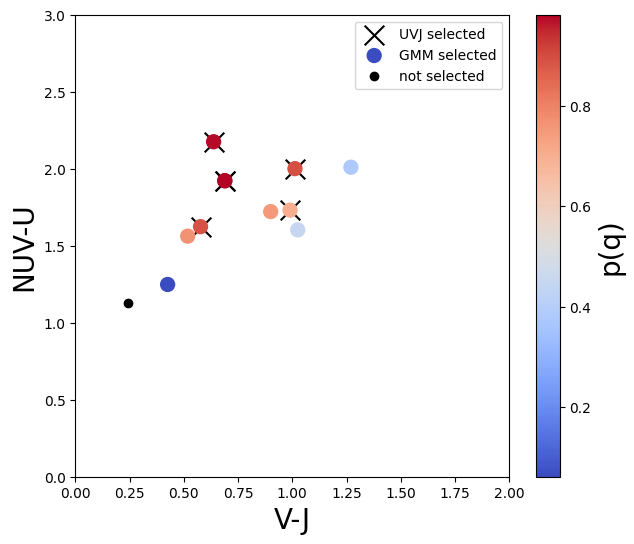

In [6]:
plt.figure(figsize=(7,6))
sel2 = sel_uvj_whitaker_2012(zout_m)
plt.scatter(zout_m['vj'][sel2],zout_m['NUVU'][sel2],marker='x',s=200,color='black',label='UVJ selected')
sc = plt.scatter(zout_m['vj'][pqsel],zout_m['NUVU'][pqsel],cmap='coolwarm'\
                 ,c=zout_m['p(q)_50'][pqsel],s=100,label='GMM selected')
plt.scatter(zout_m['vj'][~pqsel],zout_m['NUVU'][~pqsel],c='black',label='not selected')


cb = plt.colorbar(sc)
cb.set_label('p(q)',fontsize=20)
plt.xlim(0,2.)
plt.xlabel('V-J',fontsize=20)
plt.ylabel('NUV-U',fontsize=20)
plt.ylim(0,3.)
plt.legend()
plt.show()